# EXAMPLE: Ridgecrest PE analysis
This notebook shows a quick pass over the Ridgecrest 2019 IU.ANMO BHZ hour: waveform snippet, permutation-entropy features, and a simple scikit-learn logistic model.

In [10]:
from sklearn.model_selection import train_test_split
import obspy
import sys
from pathlib import Path

root = Path.cwd()
# If launched from notebooks/, go one level up to find src
candidate = root.parent / "src"
if candidate.exists():
    sys.path.append(str(candidate.resolve()))
else:
    sys.path.append(str((root / "src").resolve()))


## Data setup
Resolve the data directory, download the Ridgecrest MiniSEED if missing, and define paths for raw features and labeled CSVs.

In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.clients.fdsn import Client
from permutation_entropy.features import (
    permutation_entropy,
    weighted_permutation_entropy,
    multiscale_pe,
    ordinal_pattern,
)
from permutation_entropy.models import train_logistic, evaluate, predict_proba
from data_features.ingest import process

# Resolve data directory whether running from repo root or notebooks/
root = Path.cwd()
candidates = [root / "data", root.parent / "data"]
DATA_DIR = None
for c in candidates:
    if (c / "iris_anmo_ridgecrest.mseed").exists():
        DATA_DIR = c
        break
if DATA_DIR is None:
    DATA_DIR = candidates[0]
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    # Download the Ridgecrest hour if missing
    client = Client("IRIS")
    t0 = obspy.UTCDateTime("2019-07-06T03:00:00")
    st = client.get_waveforms(
        "IU", "ANMO", "00", "BHZ", t0, t0 + 3600, attach_response=False
    )
    st.write(str(DATA_DIR / "iris_anmo_ridgecrest.mseed"), format="MSEED")

MSEED_PATH = DATA_DIR / "iris_anmo_ridgecrest.mseed"
FEAT_PATH = DATA_DIR / "iris_anmo_ridgecrest_labeled.csv"
RAW_FEAT_PATH = DATA_DIR / "iris_anmo_ridgecrest_features.csv"

# If features/labeled CSV missing, generate from MiniSEED and auto-label mainshock window (~1190-1220 s)
if not RAW_FEAT_PATH.exists():
    process(MSEED_PATH, RAW_FEAT_PATH, window_s=30, hop_s=5, m=4, taus=[1, 2, 3, 4])
if not FEAT_PATH.exists():
    df_tmp = pd.read_csv(RAW_FEAT_PATH)
    df_tmp["label"] = (df_tmp["start_sec"].between(1180, 1220)).astype(int)
    FEAT_PATH.write_text(df_tmp.to_csv(index=False))

plt.rcParams["figure.figsize"] = (10, 3)


## Feature table and labels
Load the precomputed permutation-entropy features; if labels are missing, recreate them for the mainshock window (~1180-1220 s).

In [12]:
# Load labeled feature table
# Re-create labels if running against an older CSV without them
# The mainshock occurs ~1190-1220 s from 03:00 UTC
if not FEAT_PATH.exists():
    raise FileNotFoundError(f"Missing features file: {FEAT_PATH}")

df = pd.read_csv(FEAT_PATH)
if 'label' not in df.columns:
    df['label'] = (df['start_sec'].between(1180, 1220)).astype(int)


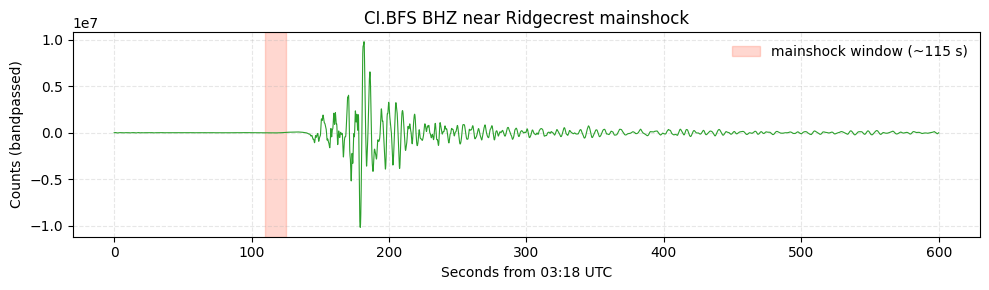

In [13]:
# Closer station (CI.BFS) for a clearer mainshock pulse
bfs_path = DATA_DIR / 'ci_bfs_ridgecrest_mainshock.mseed'
if not bfs_path.exists():
    client = Client('IRIS')
    t0 = obspy.UTCDateTime('2019-07-06T03:18:00')
    st_bfs = client.get_waveforms('CI','BFS','*','BHZ', t0, t0 + 10*60, attach_response=False)
    st_bfs.write(str(bfs_path), format='MSEED')

st_bfs = read(str(bfs_path))
tr_bfs = st_bfs[0].copy().detrend('linear').detrend('demean')
tr_bfs.filter('bandpass', freqmin=0.03, freqmax=1.0, corners=4, zerophase=True)
plt.figure(figsize=(10,3))
plt.plot(tr_bfs.times(), tr_bfs.data, lw=0.8, color="#2ca02c")
plt.axvspan(110, 125, color='tomato', alpha=0.25, label='mainshock window (~115 s)')
plt.grid(alpha=0.3, linestyle='--')
plt.xlabel('Seconds from 03:18 UTC')
plt.ylabel('Counts (bandpassed)')
plt.title('CI.BFS BHZ near Ridgecrest mainshock')
plt.legend(frameon=False)
plt.tight_layout()


## Class balance and model training
Check the labeled feature table, inspect class balance, then fit a logistic regression with a stratified split to avoid overfitting metrics.

In [14]:
# Load features and inspect class balance
print('Head:')
display(df.head())
print('\nClass balance:')
print(df['label'].value_counts())


Head:


,label,start_sec,pe,wpe,mpe_tau1,mpe_tau2,mpe_tau3,mpe_tau4
0,0,0.0,0.790880,0.482832,0.790880,0.704095,0.606717,0.604729
1,0,5.0,0.782027,0.475589,0.782027,0.695481,0.597217,0.583890
2,0,10.0,0.783478,0.502771,0.783478,0.685918,0.585841,0.565013
3,0,15.0,0.747632,0.469834,0.747632,0.638884,0.537161,0.502749
4,0,20.0,0.752685,0.475992,0.752685,0.633178,0.529593,0.506217



Class balance:
label
0    706
1      9
Name: count, dtype: int64


In [15]:
# Train a logistic regression on the labeled features
feature_cols = [c for c in df.columns if c not in ["label"]]
X = df[feature_cols]
y = df["label"]
stratify = y if y.nunique() > 1 else None
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify
)
model = train_logistic(X_tr, y_tr)
acc, auc = evaluate(model, X_val, y_val)
probs = predict_proba(model, X)
df["prob"] = probs
acc, auc


(0.9230769230769231, 0.9929078014184397)

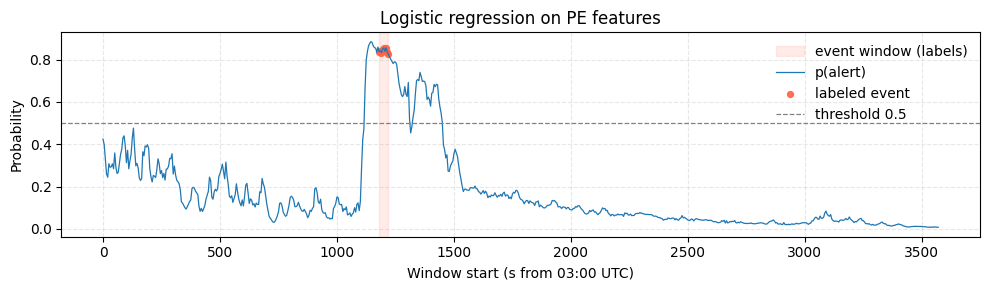

In [16]:
# Plot probabilities vs. time
plt.figure(figsize=(10,3))
plt.axvspan(1180, 1220, color='tomato', alpha=0.12, label='event window (labels)')
plt.plot(df['start_sec'], df['prob'], lw=0.9, color="#1f77b4", label='p(alert)')
plt.scatter(df.loc[df.label==1, 'start_sec'], df.loc[df.label==1, 'prob'], color='tomato', label='labeled event', s=18, alpha=0.9)
plt.axhline(0.5, color='gray', ls='--', lw=0.9, label='threshold 0.5')
plt.grid(alpha=0.3, linestyle='--')
plt.xlabel('Window start (s from 03:00 UTC)')
plt.ylabel('Probability')
plt.title('Logistic regression on PE features')
plt.legend(frameon=False)
plt.tight_layout()


## Ordinal patterns
Inspect the distribution of ordinal patterns in a mainshock window to see which temporal motifs dominate (ties are broken deterministically).

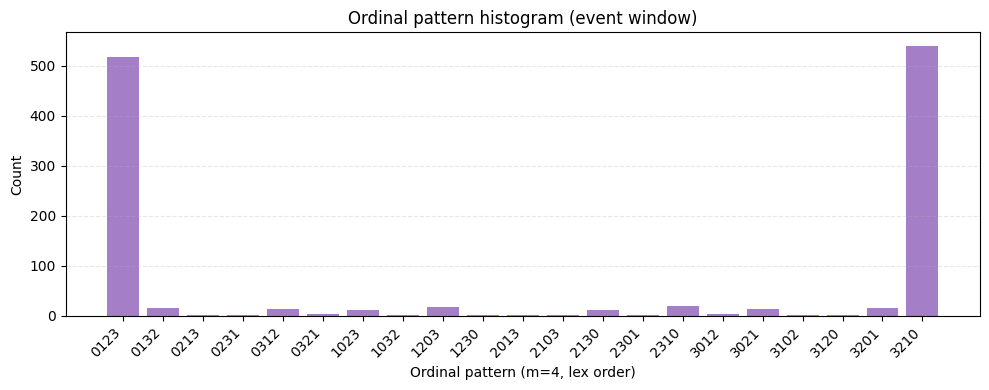

In [17]:
# Ordinal-pattern histogram for one event window (book-like ordering)
event_start = 1190
event_end = 1190 + 30
start = int(event_start * sr)
end = int(event_end * sr)
win = tr.data[start:end]

m = 4
tau = 1
counts = {}
for i in range(len(win) - (m-1)*tau):
    pat = ordinal_pattern(win[i:i + m*tau:tau])
    counts[pat] = counts.get(pat, 0) + 1

# Sort lexicographically (book-style) so patterns run from 0123 up to 3210
lex_items = sorted(counts.items(), key=lambda kv: kv[0])
labels = [''.join(map(str, k)) for k,_ in lex_items]
vals = [v for _,v in lex_items]

plt.figure(figsize=(10,4))
plt.bar(range(len(vals)), vals, color="#9467bd", alpha=0.85)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylabel('Count')
plt.xlabel('Ordinal pattern (m=4, lex order)')
plt.title('Ordinal pattern histogram (event window)')
plt.tight_layout()
